In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from typing import Tuple

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

seed = 47

X, y = fetch_openml('CIFAR_10', as_frame=False, return_X_y=True)

y_int = y.astype(int)

X_initial, X_final_test, y_initial, y_final_test = train_test_split(X, y_int, test_size=0.20, random_state=seed, shuffle=True)
X_tr, X_temp_test, y_tr, y_temp_test = train_test_split(X_initial, y_initial, test_size=0.25, random_state=seed, shuffle=True)
X_val, X_te, y_val, y_te = train_test_split(X_temp_test, y_temp_test, test_size=0.50, random_state=seed, shuffle=True)

def scale_data(X_tr: np.array, X_te: np.array) -> tuple[np.array, np.array]:
    scaler = StandardScaler()
    scaler.fit(X_tr)
    X_tr_scaled = scaler.transform(X_tr)
    X_te_scaled = scaler.transform(X_te)
    return X_tr_scaled, X_te_scaled

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled, X_val_scaled = scale_data(X_tr, X_val)
X_te_scaled = scaler.transform(X_te)
X_final_test_scaled = scaler.transform(X_final_test)

X_train_final = np.vstack((X_tr_scaled, X_val_scaled))
y_train_final = np.hstack((y_tr, y_val))


In [3]:
from sklearn.metrics import accuracy_score
def errors_for_train_sizes_mlp(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int]) -> tuple[list, list, list, list]:
    tr_err_mlp = []
    te_err_mlp = []

    mlp_params = {
        'hidden_layer_sizes': (64,),
        'activation': 'relu',
        'solver': 'sgd',
        'learning_rate_init': 0.001,
        'batch_size': 100,
        'random_state': seed,
        'max_iter': 1500
    }

    for n_tr in train_sizes:
        X_tr_subset = X_tr[:n_tr]
        y_tr_subset = y_tr[:n_tr]
        
        mlp = MLPClassifier(**mlp_params)
        mlp.fit(X_tr_subset, y_tr_subset)

        y_tr_pred = mlp.predict(X_tr_subset)
        tr_err = 1 - accuracy_score(y_tr_subset, y_tr_pred)
        tr_err_mlp.append(tr_err)
        
        y_te_pred = mlp.predict(X_te)
        te_err = 1 - accuracy_score(y_te, y_te_pred)
        te_err_mlp.append(te_err)
    return tr_err_mlp, te_err_mlp

In [4]:
def plot_errors_for_train_sizes_mlp_lr(tr_err_mlp: list, te_err_mlp: list, train_sizes: list[int]) -> None:
    plt.semilogx(train_sizes, tr_err_mlp, label='MLP Training Error', marker='x', color = "orange")
    plt.semilogx(train_sizes, te_err_mlp, label='MLP Testing Error', marker='x', color = "orange", linestyle = "--")

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

Best hyperparameters performance:
Training accuracy: 0.9673095238095238
Validation accuracy: 0.4806666666666667
Test accuracy: 0.48891666666666667


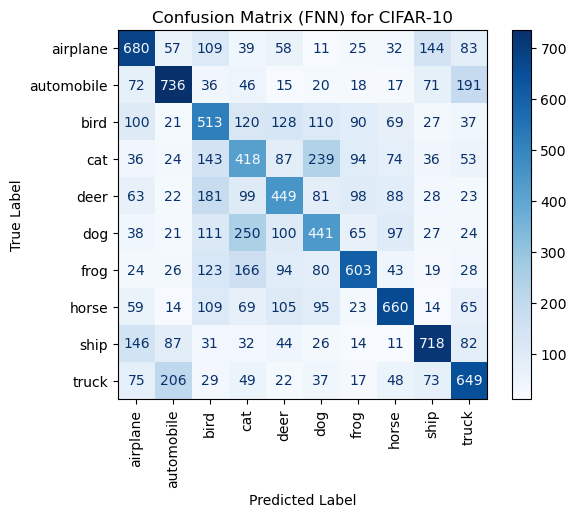

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_hyperparams = {
    'hidden_layer_sizes': (256, 128, 64),
    'activation': 'relu', 
    'solver': 'adam',
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.001,
    'max_iter': 2000,
    'alpha': 0.0005,
    'batch_size': 256,
}

def train_mlp_with_hyperparameters(best_hyperparams, X_tr, y_tr, X_val, y_val, X_te_scaled, y_te, seed) -> Tuple[float, float, float]:
    mlp = MLPClassifier(**best_hyperparams, shuffle=True, random_state=seed, verbose=False)
    mlp.fit(X_tr, y_tr)
    train_accuracy = mlp.score(X_tr, y_tr)
    val_accuracy = mlp.score(X_val, y_val)
    test_accuracy = mlp.score(X_te_scaled, y_te)
    
    print('Best hyperparameters performance:')
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    return mlp, train_accuracy, val_accuracy, test_accuracy

mlp_model, train_accuracy, val_accuracy, test_accuracy = train_mlp_with_hyperparameters(best_hyperparams, X_train_final, y_train_final, X_te_scaled, y_te, X_final_test_scaled, y_final_test, seed)

y_final_pred = mlp_model.predict(X_final_test_scaled)

conf_matrix = confusion_matrix(y_final_test, y_final_pred)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
disp.ax_.tick_params(axis='x', labelrotation=90)
plt.title('Confusion Matrix (FNN) for CIFAR-10')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

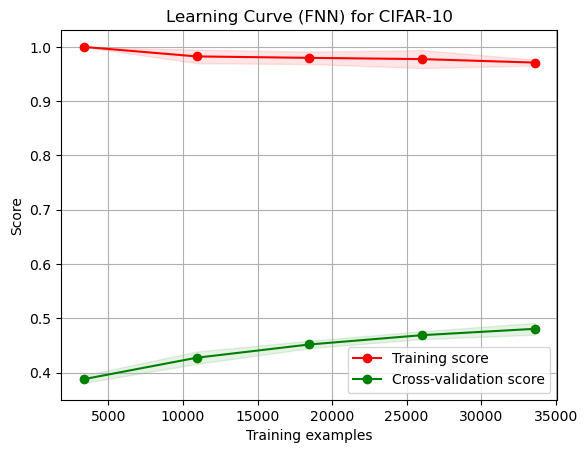

In [6]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, cv, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    
mlp = MLPClassifier(**best_hyperparams, shuffle=True, random_state=seed, verbose=False)

plot_learning_curve(mlp, "Learning Curve (FNN) for CIFAR-10", X_train_final, y_train_final, cv=5)

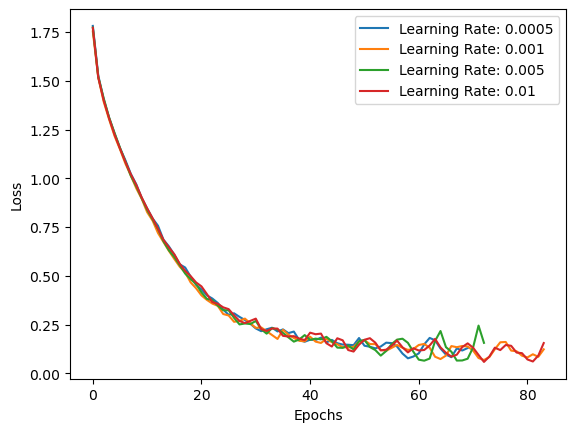

In [7]:
def errors_for_learning_rates_mlp(X_tr: np.array, y_tr: np.array, seed: int, learning_rates: list[float]) -> list[list]:
    err_curves = []
    for lr in learning_rates:
        mlp_params = {
            'hidden_layer_sizes': (256, 128, 64),
            'activation': 'relu', 
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001,
            'max_iter': 2000,
            'alpha': 0.0005,
            'batch_size': 256,
        }
        mlp = MLPClassifier(**mlp_params)
        mlp.fit(X_tr, y_tr)
        
        err_curves.append(mlp.loss_curve_)
    
    return err_curves 

def plot_errors_for_learning_rates_mlp(err_curves: list[list], learning_rates: list[float]) -> None:
    for i, curve in enumerate(err_curves):
        plt.plot(curve, label=f'Learning Rate: {learning_rates[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

learning_rates = [0.0005, 0.001, 0.005, 0.01]
err_curves = errors_for_learning_rates_mlp(X_tr_scaled, y_tr, seed, learning_rates)
plot_errors_for_learning_rates_mlp(err_curves, learning_rates)

/opt/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


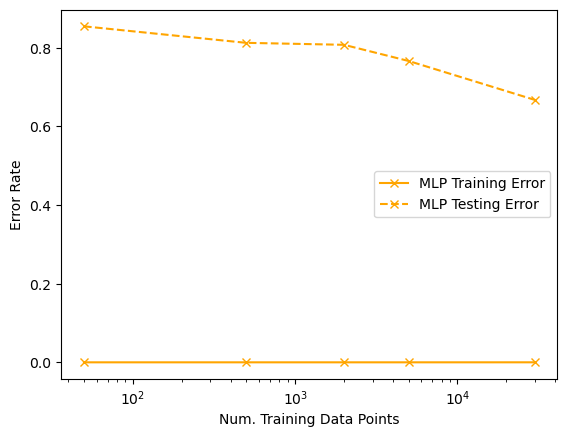

In [8]:
train_sizes = [50, 500, 2000, 5000, 30000]
tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_tr_scaled, y_tr, X_final_test, y_final_test, seed, train_sizes)
plot_errors_for_train_sizes_mlp_lr(tr_err_mlp, te_err_mlp, train_sizes)

In [13]:
from sklearn.metrics import classification_report

mlp = MLPClassifier(**best_hyperparams, shuffle=True, random_state=seed, verbose=False)
mlp.fit(X_train_final, y_train_final)
y_pred = mlp.predict(X_final_test_scaled)
report = classification_report(y_final_test, y_pred, target_names=class_names)

print(report)


/opt/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

    airplane       0.12      0.01      0.01      1238
  automobile       0.27      0.07      0.12      1222
        bird       0.02      0.00      0.00      1215
         cat       0.08      0.01      0.02      1204
        deer       0.05      0.05      0.05      1132
         dog       0.00      0.00      0.00      1174
        frog       0.11      0.90      0.20      1206
       horse       0.15      0.00      0.01      1213
        ship       0.12      0.04      0.06      1191
       truck       0.22      0.00      0.00      1205

    accuracy                           0.11     12000
   macro avg       0.11      0.11      0.05     12000
weighted avg       0.12      0.11      0.05     12000



/opt/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
